This notebook studies the linearity in the learned DAG vs random DAGs and can be used to replicate **Fig. S11C**.

In [48]:
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
from scipy.stats import zscore
import scanpy as sc
import pandas as pd
from tqdm import tqdm

In [5]:
with open("../../data/estimated_dag.pkl", 'rb') as file:
	dag = pickle.load(file)
order = list(nx.topological_sort(dag))

with open("../../data/gene_dict.pkl", 'rb') as file:
	gene_dict = pickle.load(file)

obs_samples = np.load("../../data/samples+/ctrl.npy")

### regression over parents in the learned dag

In [7]:
responses = []
r_scores = {}

for gene in order:
	gene_parents = list(dag.predecessors(gene))

	if len(gene_parents) != 0:
		if gene not in responses:
			responses.append(gene)

		X = obs_samples[[gene_dict[i] for i in gene_parents], :].T
		y = obs_samples[gene_dict[gene], :].reshape(-1)
		reg = LinearRegression().fit(X, y)
		r_scores[gene] = reg.score(X,y)**0.5

### regression over parents in random dags

In [34]:
n = len(dag.nodes)
p = len(dag.edges)/(n*(n-1)/2)

In [49]:
avg_scores = []

for _ in tqdm(range(100)):
	random_dag = nx.erdos_renyi_graph(n, p, directed=True)
	random_perm = {list(dag.nodes)[i]:i for i in np.random.permutation(n)}
	inv_random_perm = {random_perm[i]:i for i in random_perm.keys()}

	random_r_scores = []

	for gene in random_perm.keys():
		gene_parents = [inv_random_perm[i] for i in random_dag.predecessors(random_perm[gene])]

		if len(gene_parents) != 0:
			X = obs_samples[[gene_dict[i] for i in gene_parents], :].T
			y = obs_samples[gene_dict[gene], :].reshape(-1)
			reg = LinearRegression().fit(X, y)
			random_r_scores.append(reg.score(X,y)**0.5)
	avg_scores.append(np.average(random_r_scores))

100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


### Supplementary Fig. 14C

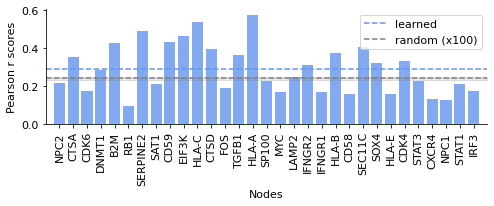

In [70]:
fig, ax = plt.subplots(1,1,figsize=(7,3))
plt.rcParams.update({'font.size': 11})

plt.bar(list(r_scores.keys()), list(r_scores.values()), color='cornflowerblue', alpha=0.8)
plt.xticks(rotation=90)
plt.xlim(-1,31)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.ylabel('Pearson r scores')
plt.xlabel('Nodes')

plt.hlines(np.average(list(r_scores.values())), xmin=-1, xmax=31, color='cornflowerblue', linestyles='--', label='learned')
plt.hlines(np.average(avg_scores), xmin=-1, xmax=31, color='grey', linestyles='--', label='random (x100)')
plt.fill_between(np.arange(-1,32,1), [np.average(avg_scores)-np.std(avg_scores)]*33, [np.average(avg_scores)+np.std(avg_scores)]*33, color='grey', alpha=.2)

plt.legend()
plt.tight_layout()
plt.savefig('fig/r_score_rotate.pdf')